<a href="https://colab.research.google.com/github/wheemin-2/24-2-ESAA/blob/main/1111_HW_Regression_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **회귀 실습 - 자전거 대여 수요 예측**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **데이터 클렌징 및 가공과 데이터 시각화**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore',category = RuntimeWarning)

bike_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


변수 설명

* datetime : hourly date + timestamp
* season : 1=봄, 2=여름, 3=가을, 4=겨울
* holiday : 1 = 토, 일을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날
* workingday : 1 = 주중, 0 = 주말 및 휴일
* weather : 1 = 맑음, 약간 구름 낀 흐림, 2 = 안개/안개+흐림, 3 = 가벼운 눈/가벼운 비 + 천둥, 4 = 심한 눈/비, 천둥/번개
* temp, atemp : 온도(섭씨), 체감온도(섭씨)
* humidity : 상대습도
* windspeed : 풍속
* casual : 사전에 등록되지 않은 사용자가 대여한 횟수
* registered : 사전에 등록된 사용자가 대여한 횟수
* count : 대여 횟수 >> 결정값

In [4]:
# datetime : object > datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
# 불필요한 피처 칼럼 삭제 (datetime, casual, registered)
# casual + registered = count
# casual/registered는 따로 필요하지 않고 상관도가 높아 예측을 저해할 우려가 있으므로 삭제
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

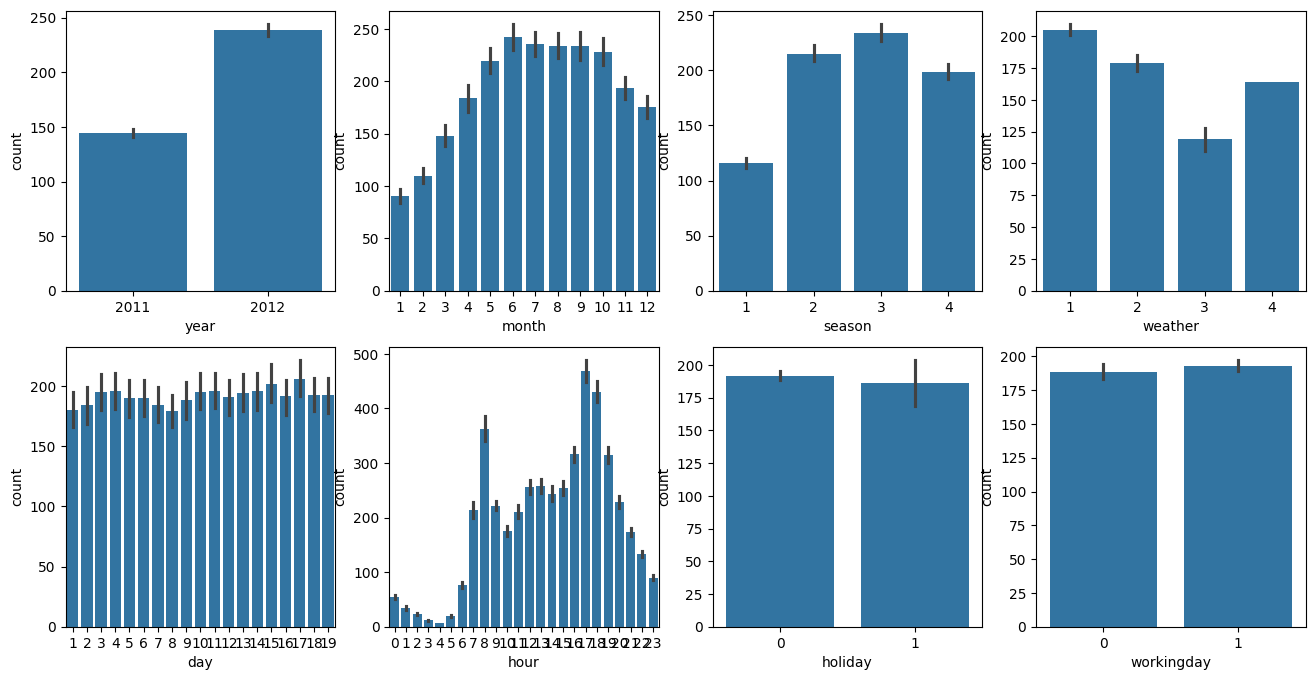

In [6]:
# 피처별 Target 값 분포 시각화
fig, axs = plt.subplots(figsize=(16,8), nrows=2, ncols=4)
cat_features = ['year','month','season','weather','day','hour','holiday','workingday']

# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

시각화 결과 해석

* year별 count : 2011년보다 2012년에 자전거를 더 많이 빌림 (시간이 지날수록 자전거 대여 횟수가 지속적으로 증가하였음)
* month, season : 여름~가을에 많이 빌림
* weather : 1,2 (맑거나 약간 안개 있는 경우)가 높음  / 3,4 : 눈/비가 있는 경우
* day 간의 차이는 크지 않음
* hour : 출/퇴근 시간에 많이 빌림
* holiday, workingday : 주중일 경우가 상대적으로 약간 높음

In [7]:
# 다양한 회귀 모델 적용
# 예측 성능은 RMSLE (Root Mean Square Log Error)
# sklearn은 RMSLE를 지원하지 않으므로 직접 함수 생성

from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)    # log값 변환 시 NaN 등의 이슈를 피하기 위해 log1p 사용
    log_pred = np.log1p(pred)
    squared_error = (log_y-log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:3f}'.format(rmsle_val, rmse_val, mae_val))

*RMSLE 구할 때 발생할 수 있는 오류*

데이터 값의 크기에 따라 over/underflow 오류가 발생하기 쉬움


```
def rmsle(y, pred):
    msle = mean_squared_log_error(y, pred)
    rmsle = np.sqrt(mse)
    return rmsle
```

*log1p()의 사용*

$log1p(x)  >>  log(1+x)$ 로 변환되므로 x값이 0이더라도 무한대가 되지 않으므로 오버플로/언더플로 문제를 해결해줌

*expm1() 함수로 원래 스케일로 복원 가능*


## **로그 변환, 피처 인코딩**

### **타겟값 로그 변환**

회귀 모델 적용 전,
* 타겟값이 정규 분포인지 확인
* 카테고리형 회귀 모델의 경우 피처 원-핫 인코딩 해야함

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop('count', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924448


실제 Target 데이터 값인 Count의 수(100~400 사이에 몰려있고, 평균이 191임)를 감안하면 예측 오류로서는 비교적 큰 값임

In [9]:
# 실제 값과 예측값의 차이 확인

def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df.real_count - result_df.predicted_count)

    print(result_df.sort_values(by='diff',ascending=False)[:n_tops])

get_top_error_data(y_test, pred, 5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


가장 큰 상위 5위 오류값은 546~568, 꽤 큼

회귀에서 이렇게 큰 예측 오류가 발생하는 경우 가장 먼저 살펴볼 것?

>*Target 값의 분포가 대칭인지, skewed 인지!*

Target 값의 분포는 정규 분포 형태가 가장 좋고, 그렇지 않은 경우 회귀 예측 성능이 저하되는 경우가 발생하기 쉬움


<Axes: >

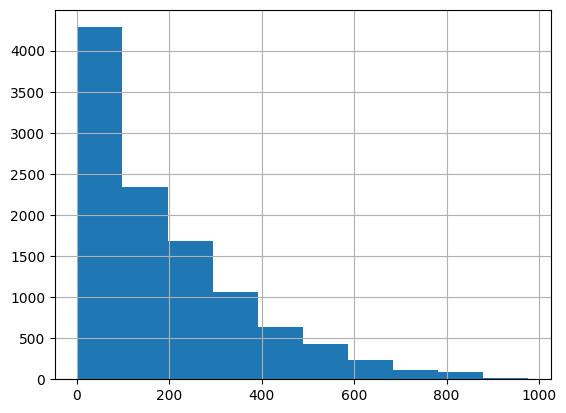

In [10]:
# 타겟값 분포 확인
y_target.hist()

시각화 결과, *right-skewed*

<Axes: >

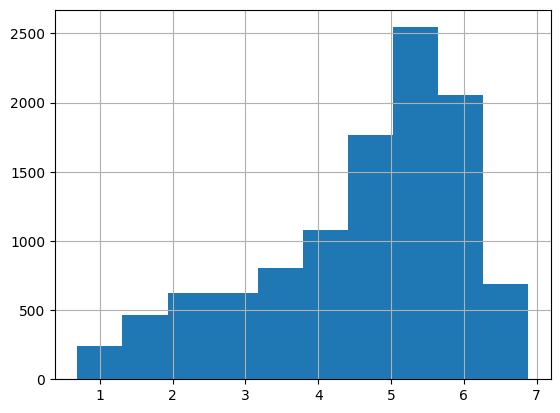

In [11]:
# 타겟값은 로그변환하는 것이 일반적임
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

완벽한 정규분포 형태는 아니지만 로그 변환 전보다는 왜곡 정도가 많이 향상됨

In [12]:
# 학습/평가 다시 수행
y_target_log = np.log1p(y_target)

# 로그 변환된 타겟값으로 다시 학습/테스트 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.2, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 타겟값 원래 스케일로 변환
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.026, RMSE: 161.617, MAE: 109.158507


*타겟 로그변환 전 결과 ) RMSLE: 1.165, RMSE: 140.900, MAE: 105.924448*

RMSLE 오류는 약간 줄어들었지만 RMSE 값은 오히려 늘어남

### **개별 피처 인코딩**

<Axes: ylabel='None'>

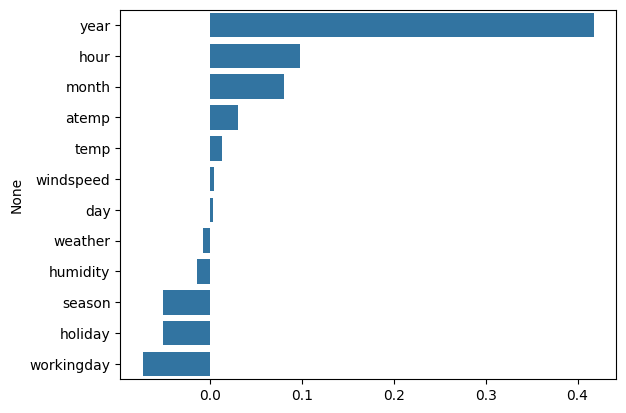

In [13]:
# 개별 피처 인코딩

coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

year, hour, month, season, holiday, workingday의 회귀 계수 영향도가 상대적으로 높음

이 피처들은 숫자형이지만 크고 작음이 의미가 있는 것이 아님 > **원-핫 인코딩을 적용해야함!!!!**

In [14]:
# One Hot Encoding ; get_dummies
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

In [15]:
# 원-핫 인코딩 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

models = [lr_reg, ridge_reg, lasso_reg]

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382012
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893353
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.802707


성능 향상 !

<Axes: ylabel='None'>

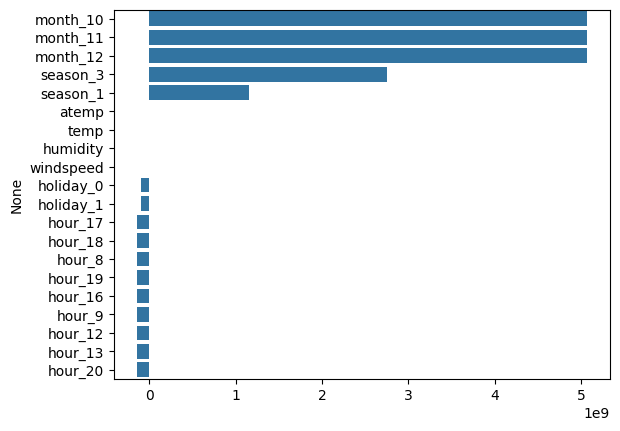

In [16]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## **회귀 트리 모델 학습/예측/평가**

In [17]:
# 회귀 트리를 이용한 회귀 예측 수행
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM 모델별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

models = [rf_reg, gbm_reg, xgb_reg, lgbm_reg]

for model in models:
    # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능, ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.237, MAE: 31.111390
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.365, MAE: 32.754231
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.356583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.028770


선형 회귀 모델보다 예측 성능이 개선되었으나 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의미는 아님, 데이터 세트의 유형에 따라 결과는 달라질 수 있음

# **회귀 실습 (2) - 캐글 주택 가격 : 고급 회귀 기법**

데이터 설명

* 미국 아이오와 State의 Ames 지방의 주택 가격정보를 포함함
* 79개의 변수
* Target : SalePrice


## **데이터 전처리 (Preprocessing)**

In [18]:
house_df_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [19]:
print('데이터 세트의 shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


PoolQC, MiscFeature, Alley, Fence : 1000개가 넘는 값이 Null   >>> drop

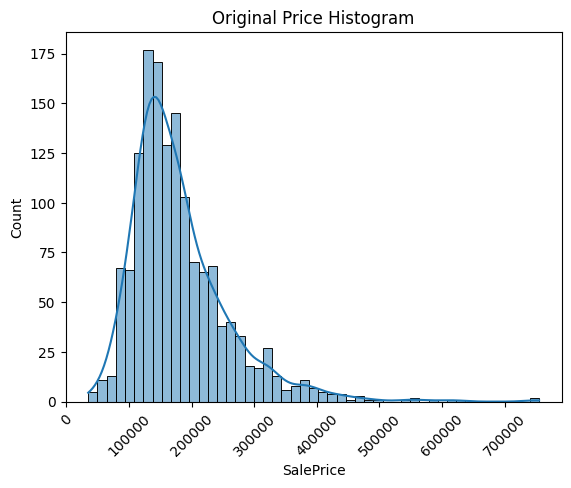

In [20]:
# 타깃값 분포 확인 (정규분포에서 너무 벗어난 경우 변환 필요)
sns.histplot(house_df['SalePrice'], kde=True)
plt.title('Original Price Histogram')
plt.xticks(rotation=45)
plt.show()

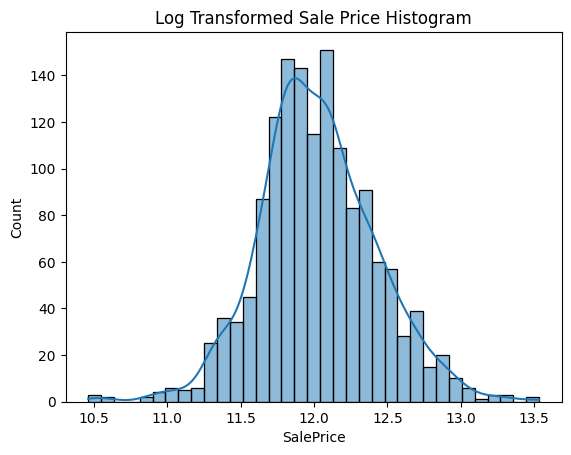

In [21]:
# log transform
sns.histplot(np.log1p(house_df['SalePrice']), kde=True)
plt.title('Log Transformed Sale Price Histogram')
plt.show()

로그 변환 시 정규분포와 분포 양상이 유사함  >>> 로그 변환 진행

In [22]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 값이 너무 많은 불필요한 칼럼 삭제
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1, inplace=True)


In [23]:
# 드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)

# Null 값이 있는 피처명, 타입 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type: \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


문자형 피처를 제외하고는 Null 값이 없어짐

In [24]:
# 문자형 피처 원-핫 인코딩 : get_dummies()

print('get_dummies() 수행 전 데이터 shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape: (1460, 75)
get_dummies() 수행 후 데이터 shape: (1460, 270)
## Null 피처의 Type :
 Series([], dtype: object)


원-핫 인코딩 후 피처 개수 변화 : 75 > 270 개

Null 값 없음

## **선형 회귀 모델 학습/예측/평가**

예측 평가는 RMSLE를 이용

앞서 타겟값을 이미 로그 변환 했으므로 예측 결과 오류게 RMSE만 적용하면 RMSLE가 자동으로 측정됨

In [25]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

In [26]:
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)


# 모델 학습/예측/평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[0.13183184688250854, 0.1274058283626615, 0.17628250556471403]

라쏘 회귀의 경우 회귀 성능이 타 회귀 방식보다 떨어지는 결과 > 라쏘는 하이퍼 파라미터 튜닝이 필요한 것으로 판단됨

In [28]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성, index는 칼럼명
    coef = pd.Series(model.coef_, index=X_features.columns)

    # +,- 각각 상위 10개의 회귀 계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

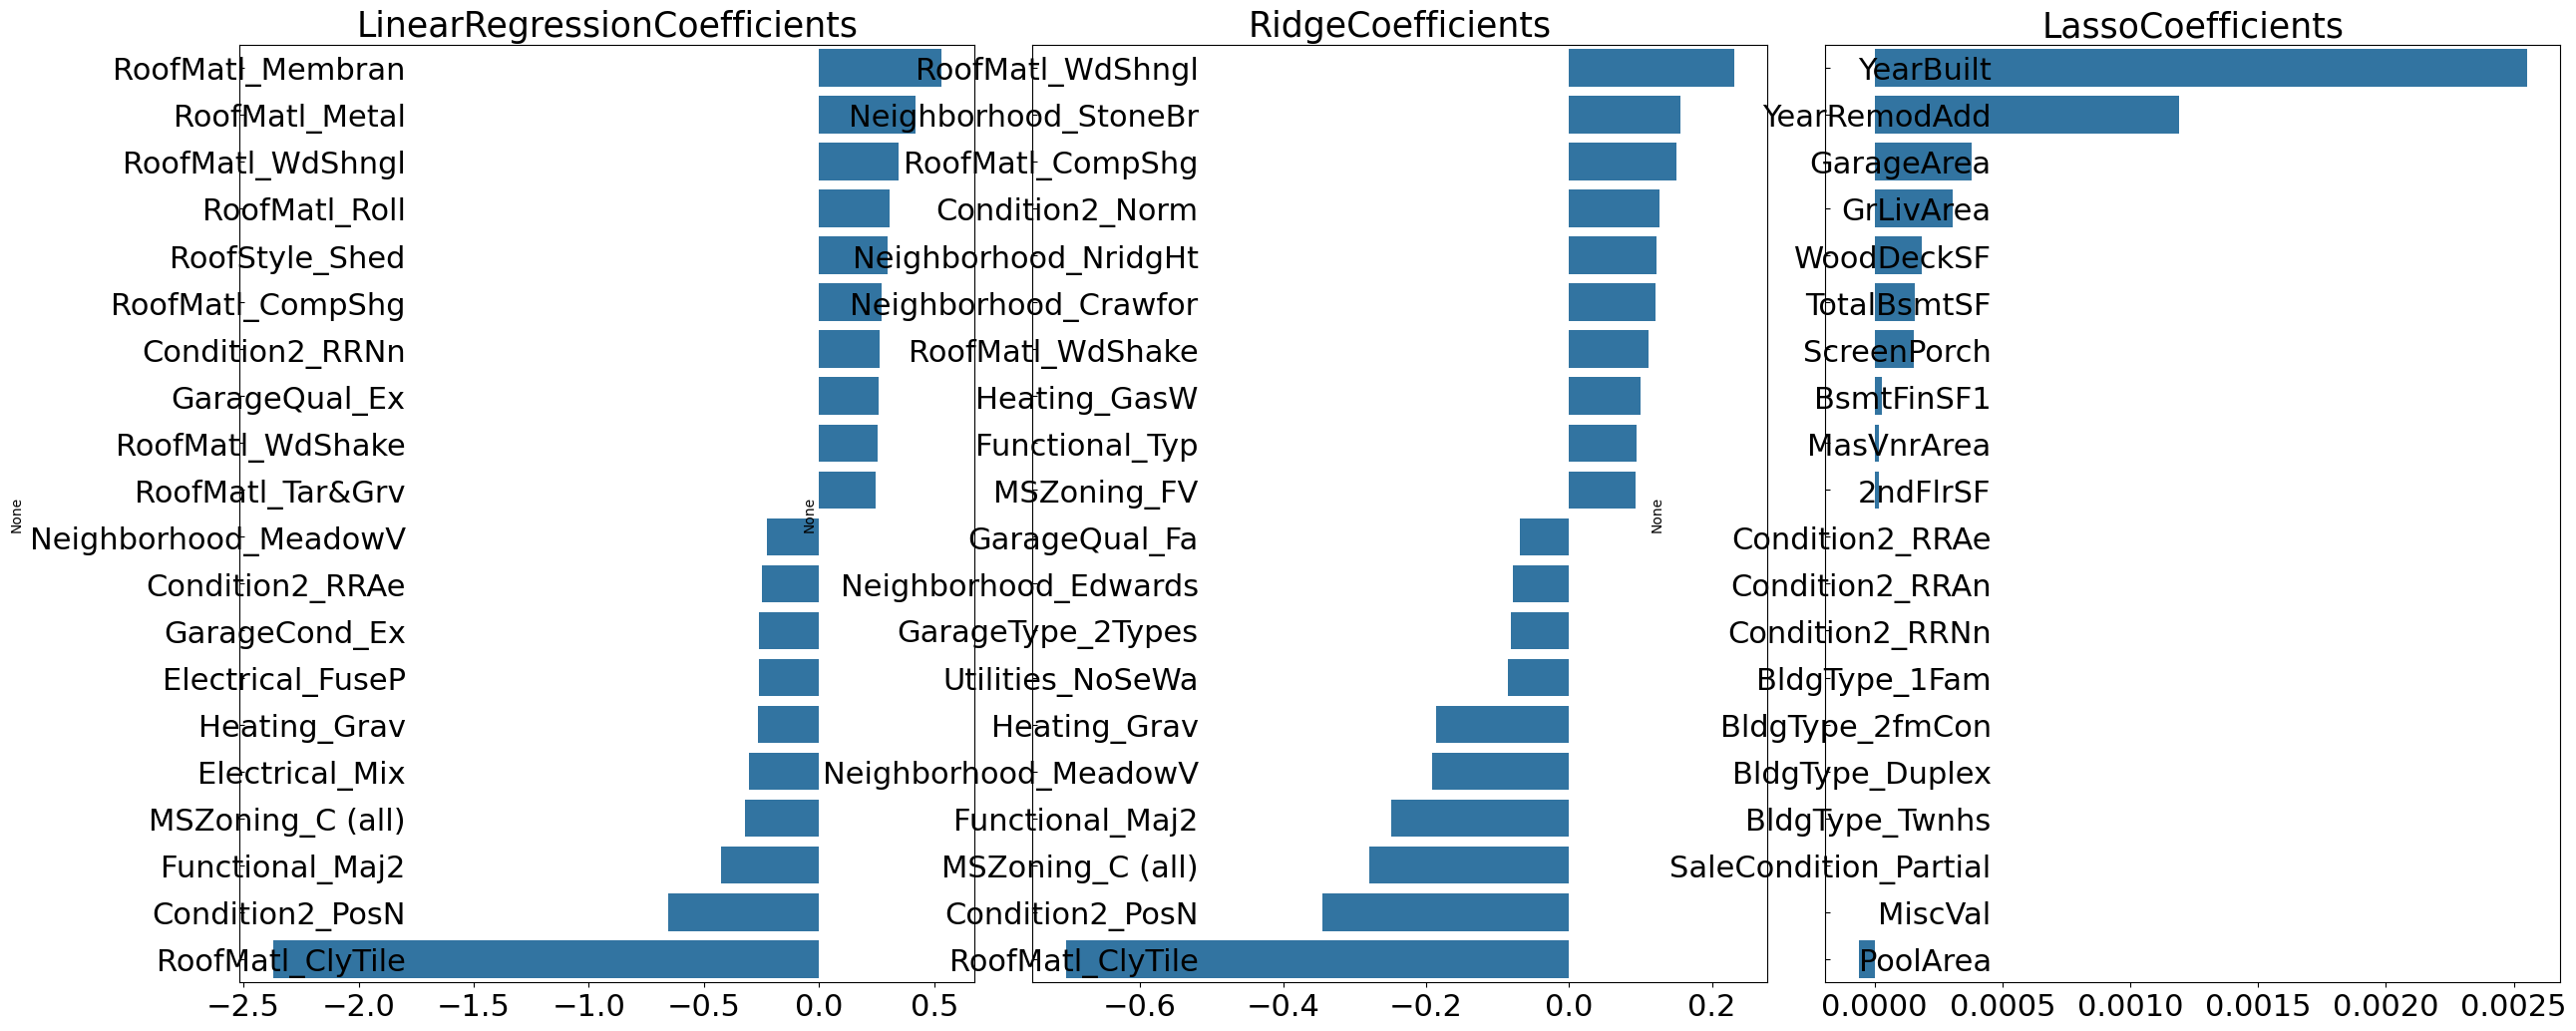

In [29]:
# 모델별 회귀 계수 시각화

def visualize_coefficient(models):
    # 3개 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()

    # 입력 인자로 받은 list(models) 에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])

        # 시각화 옵션 설정
        axs[i_num].set_title(model.__class__.__name__+'Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)

        # 시각화
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

OLS 기반의 LinearRegression, Ridge의 경우 : 회귀 계수가 유사함

라쏘 : 전체적으로 회귀 계수값이 너무 작음 + YearBuilt가 상대적으로 너무 큼 + 다른 두 모델과 양상이 다름

> 학습 데이터의 데이터 분할에 있어 문제가 있는건가? 확인

In [30]:
# 전체 데이터 세트 X_features, y_target을 5 fold 분할하여 평균 RMSE 측정
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

    for model in models:
        # 분할하지 않고 cross_val_score() 수행
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
        print('\n{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]

Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]

Lasso CV 평균 RMSE 값: 0.198


여전히 라쏘의 성능이 떨어짐 > alpha 하이퍼 파라미터 변화시켜보자!

In [31]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


lasso model : 하이퍼 파라미터 튜닝 후 예측 성능 좋아짐!

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


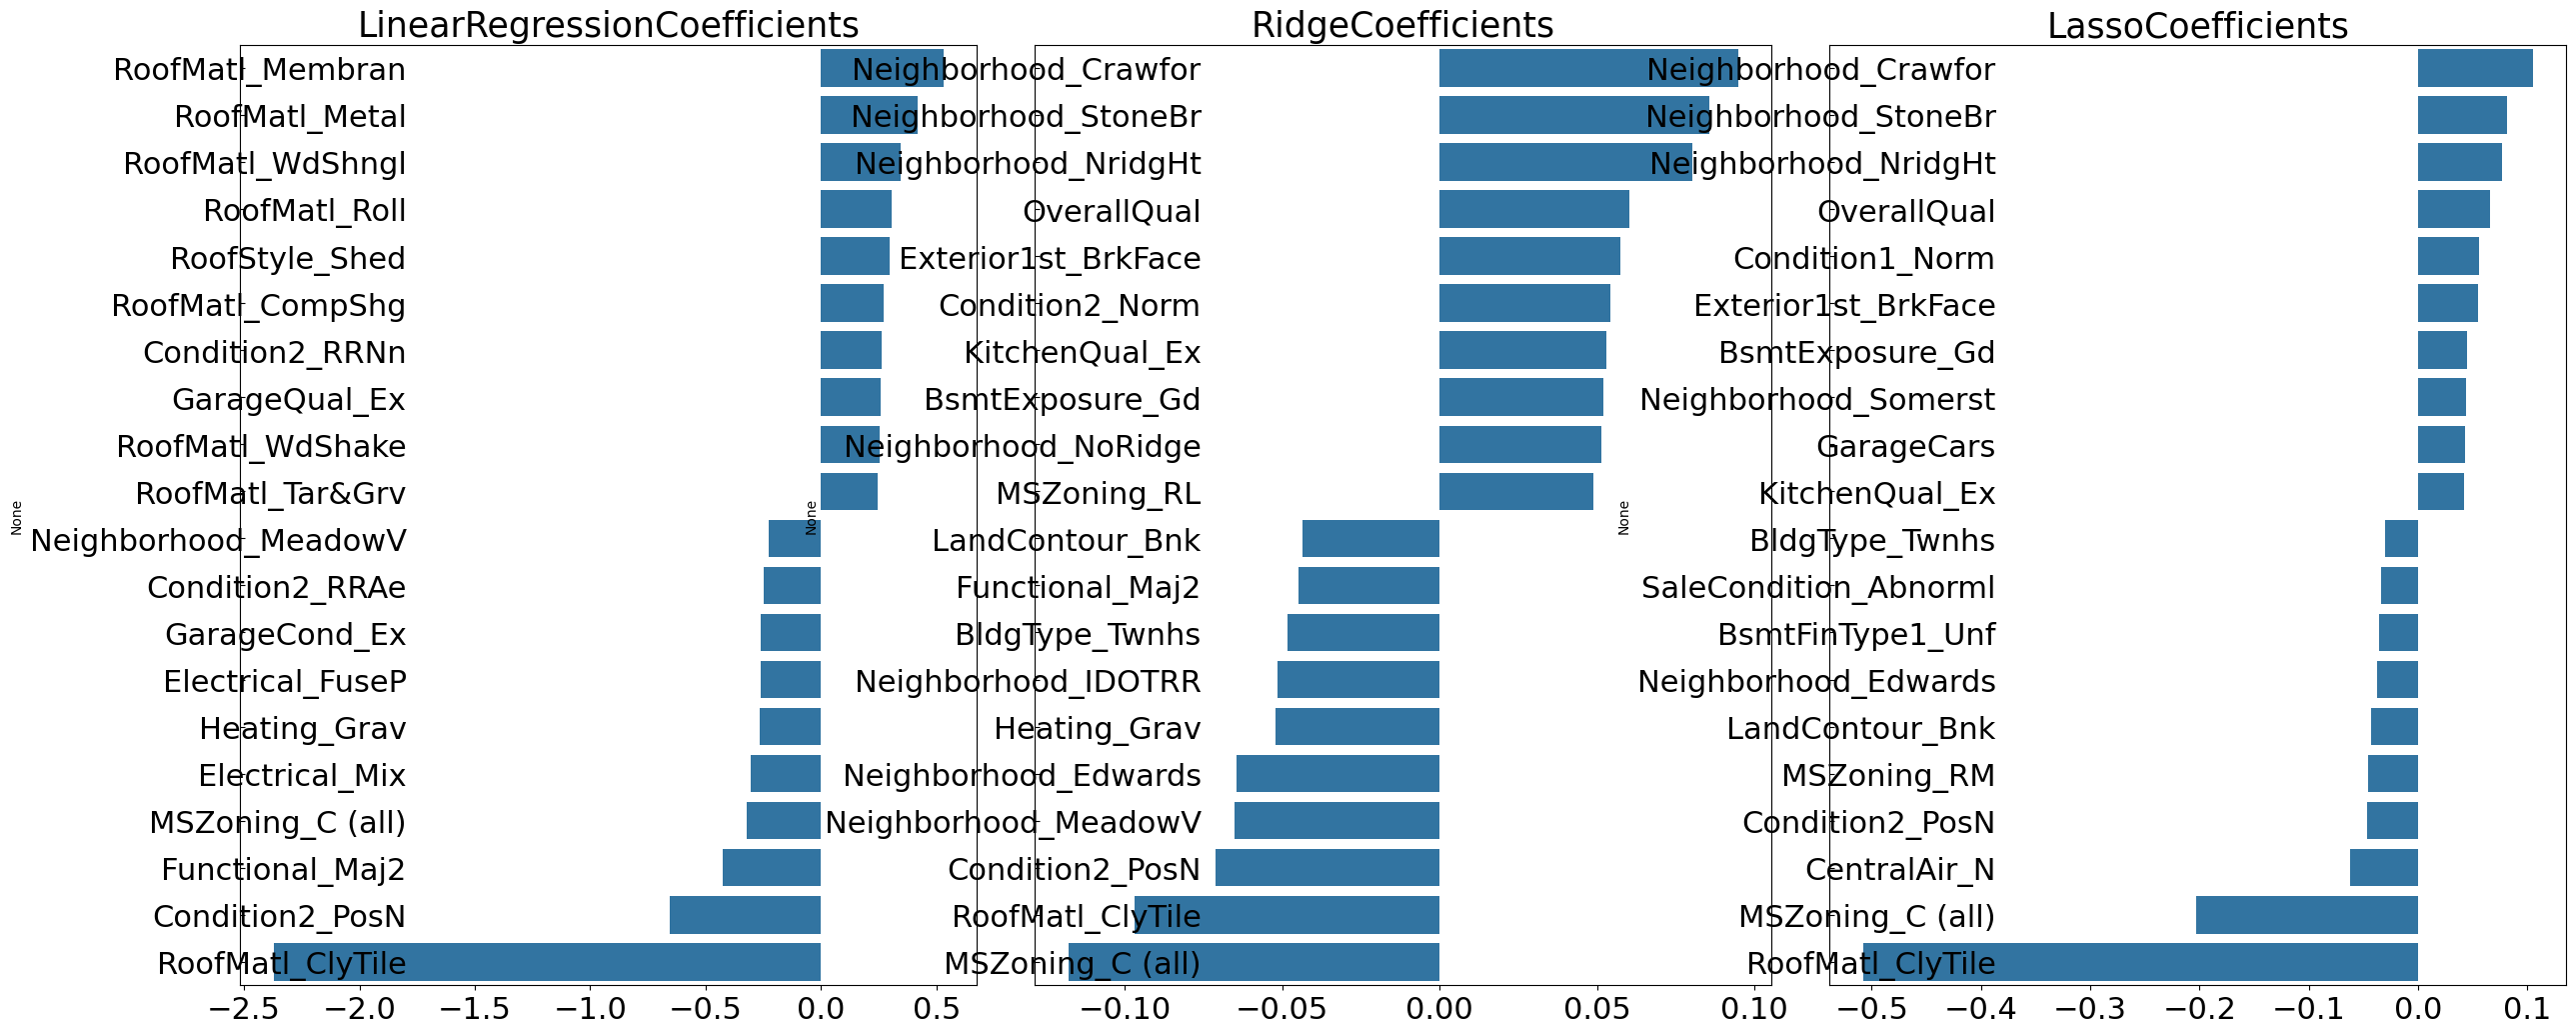

In [32]:
# 최적화 alpha 값으로 train_test_split() 적용 후 학습
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

alpha값 최적화 이후 테스트 데이터 세트의 예측 성능이 좋아짐 + 세 모델의 회귀 계수 양상이 비슷함

## **데이터 세트 추가 가공 후 학습/예측/평가**

### **skewed data 처리**

In [33]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 칼럼 index를 입력하면 해당하는 칼럼 데이터 세트 반환 : skew() 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))

# skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]

print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [34]:
# 왜곡 정도가 높은 피처 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [35]:
# 왜곡 정도가 높은 피처를 로그 변환 했으므로 다시 원-핫 인코딩 적용, 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha:{'alpha': 0.001}


Ridge 최적 alpha : 12에서 10으로 변경

평균 RMSE 값 또한 0.02정도 하락 > 성능 향상 !

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


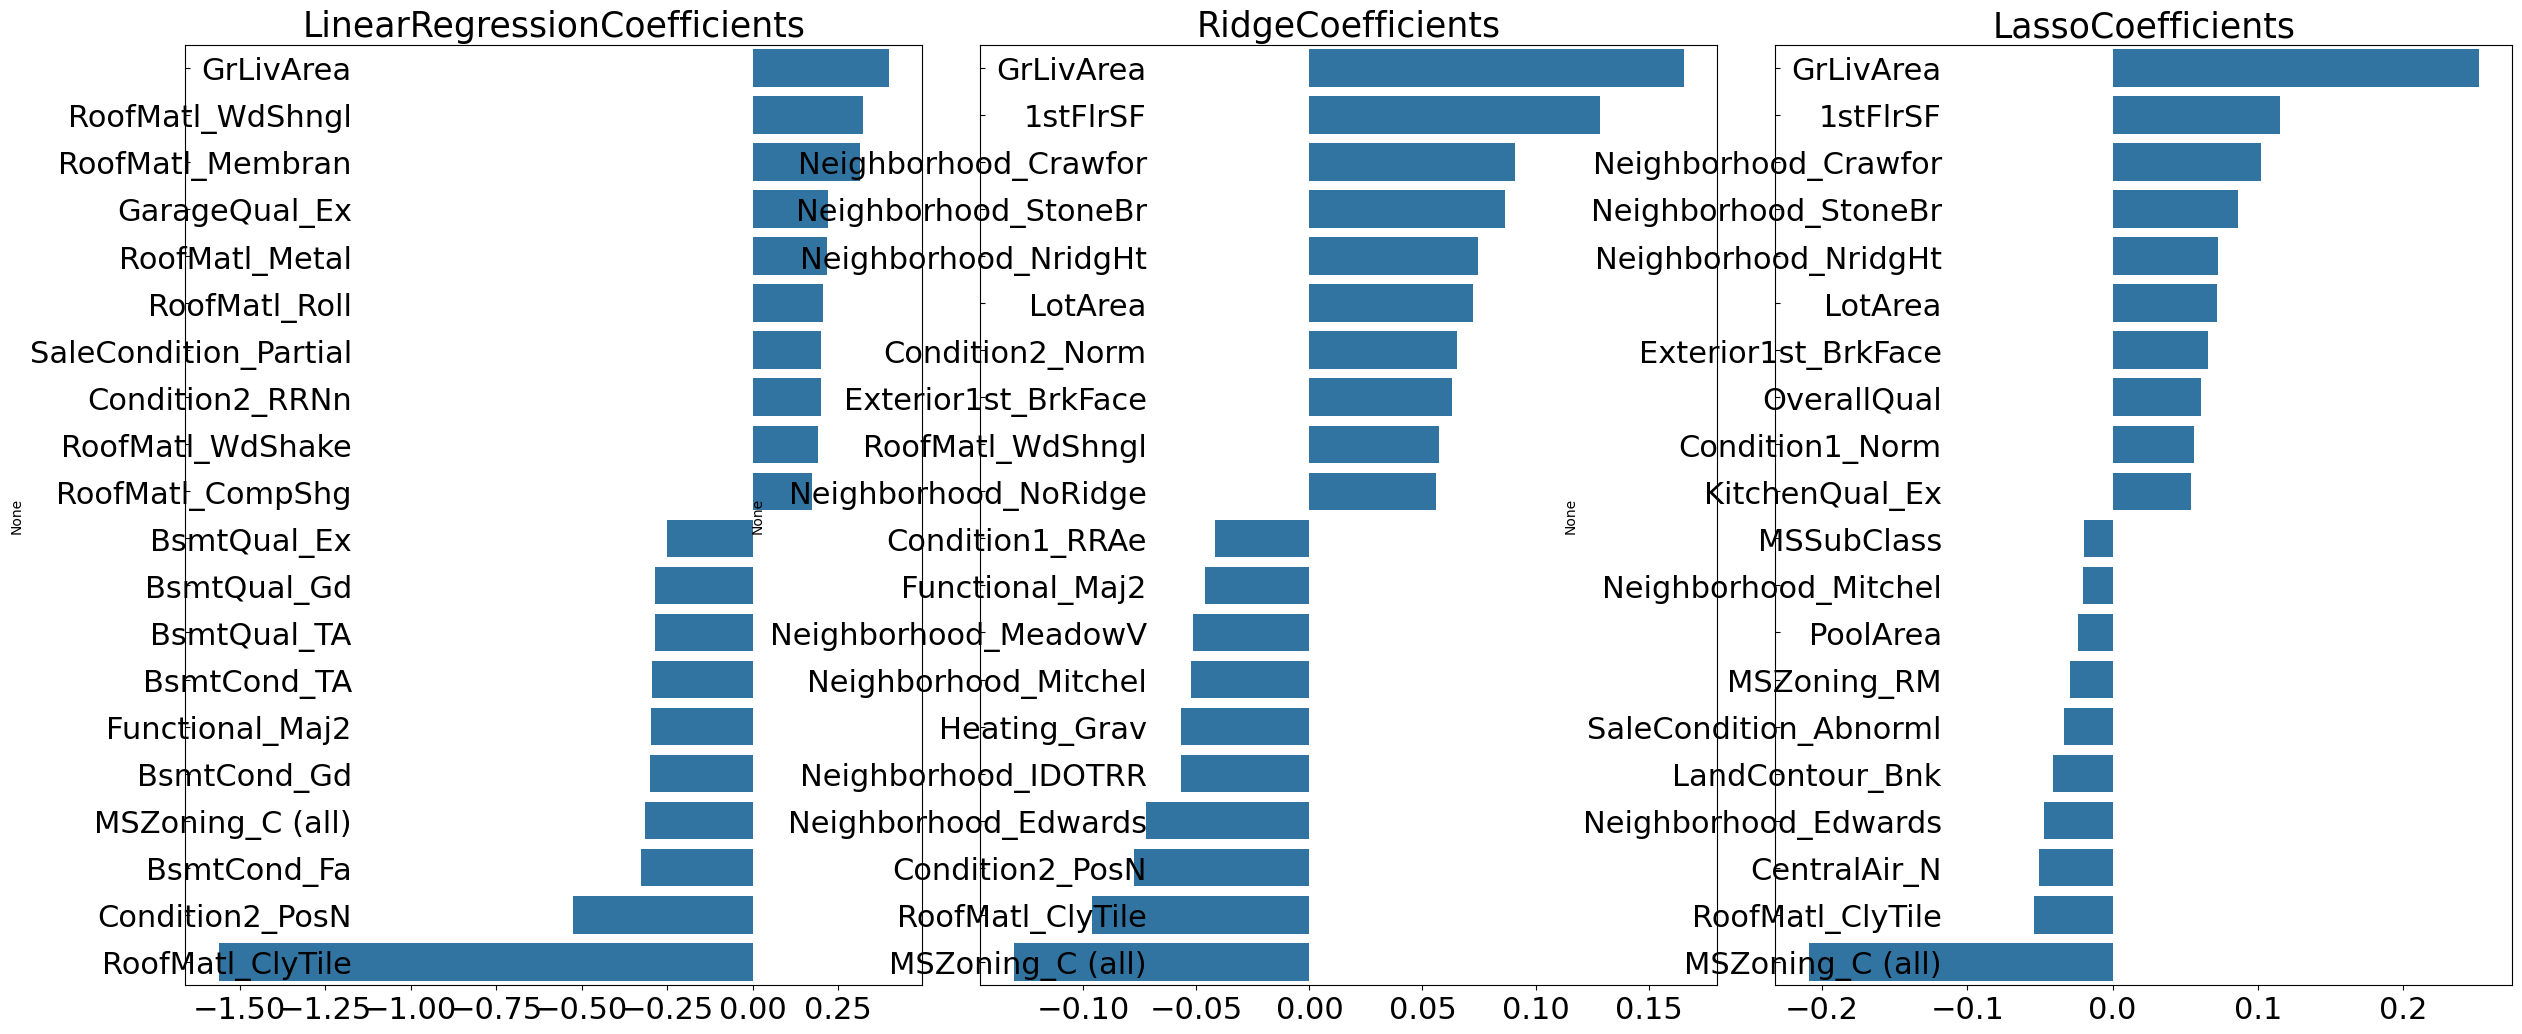

In [36]:
# 최적화 alpha 값으로 train_test_split() 적용 후 학습
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

세 모델 모두 GrLivArea(주거 공간 크기)의 회귀 계수가 가장 높은 피처가 됨 : 주거 공간의 크기가 주택 가격에 미치는 영향이 제일 높다는 합리적인 결과 도출!

### **outlier 처리**

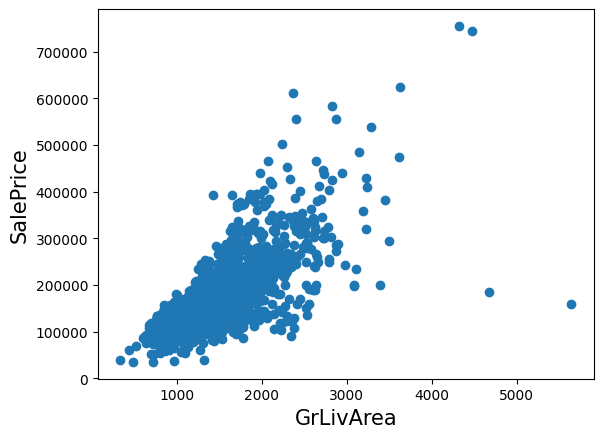

In [37]:
# 가격에 가장 큰 영향을 미치는 GrLivArea 변수(변환 전) 와 SalePrice의 관계 시각화
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

일반적으로 주거 공간이 큰 집일수록 가격이 비쌈 > GrLivArea, SalePrice 는 양의 상관도가 매우 높게 나타남

이 때 가장 오른쪽 아래의 두 점은 양의 상관관계에서 어긋나있음 (주거 공간이 굉장이 큼에도 가격이 낮음) > **이상치로 간주, 삭제!**

In [38]:
# GrLivArea, SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index : ', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# 이상치 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index :  [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 270)
이상치 삭제 후 house_df_ohe shape: (1458, 270)


산점도에서 확인한 두 점이 지워짐

In [39]:
# 업데이트 된 house_df_ohe를 기반으로 피처/타깃 데이터 다시 생성
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 이상치 제거 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


예측 수치 매우 크게 향상됨
* Ridge : 0.1275 > 0.1125
* Lasso : 0.128 > 0.1122

회귀에 중요한 영향을 미치는 피처를 위주로 이상치 데이터를 찾으려는 노력은 중요하다!

바람직한 머신러닝 모델 생성 과정 : 데이터 가공, 모델 최적화 > 결과를 기반으로 다양한 기법의 데이터 가공, 하이퍼 파라미터 기반의 모델 최적화 (반복)

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


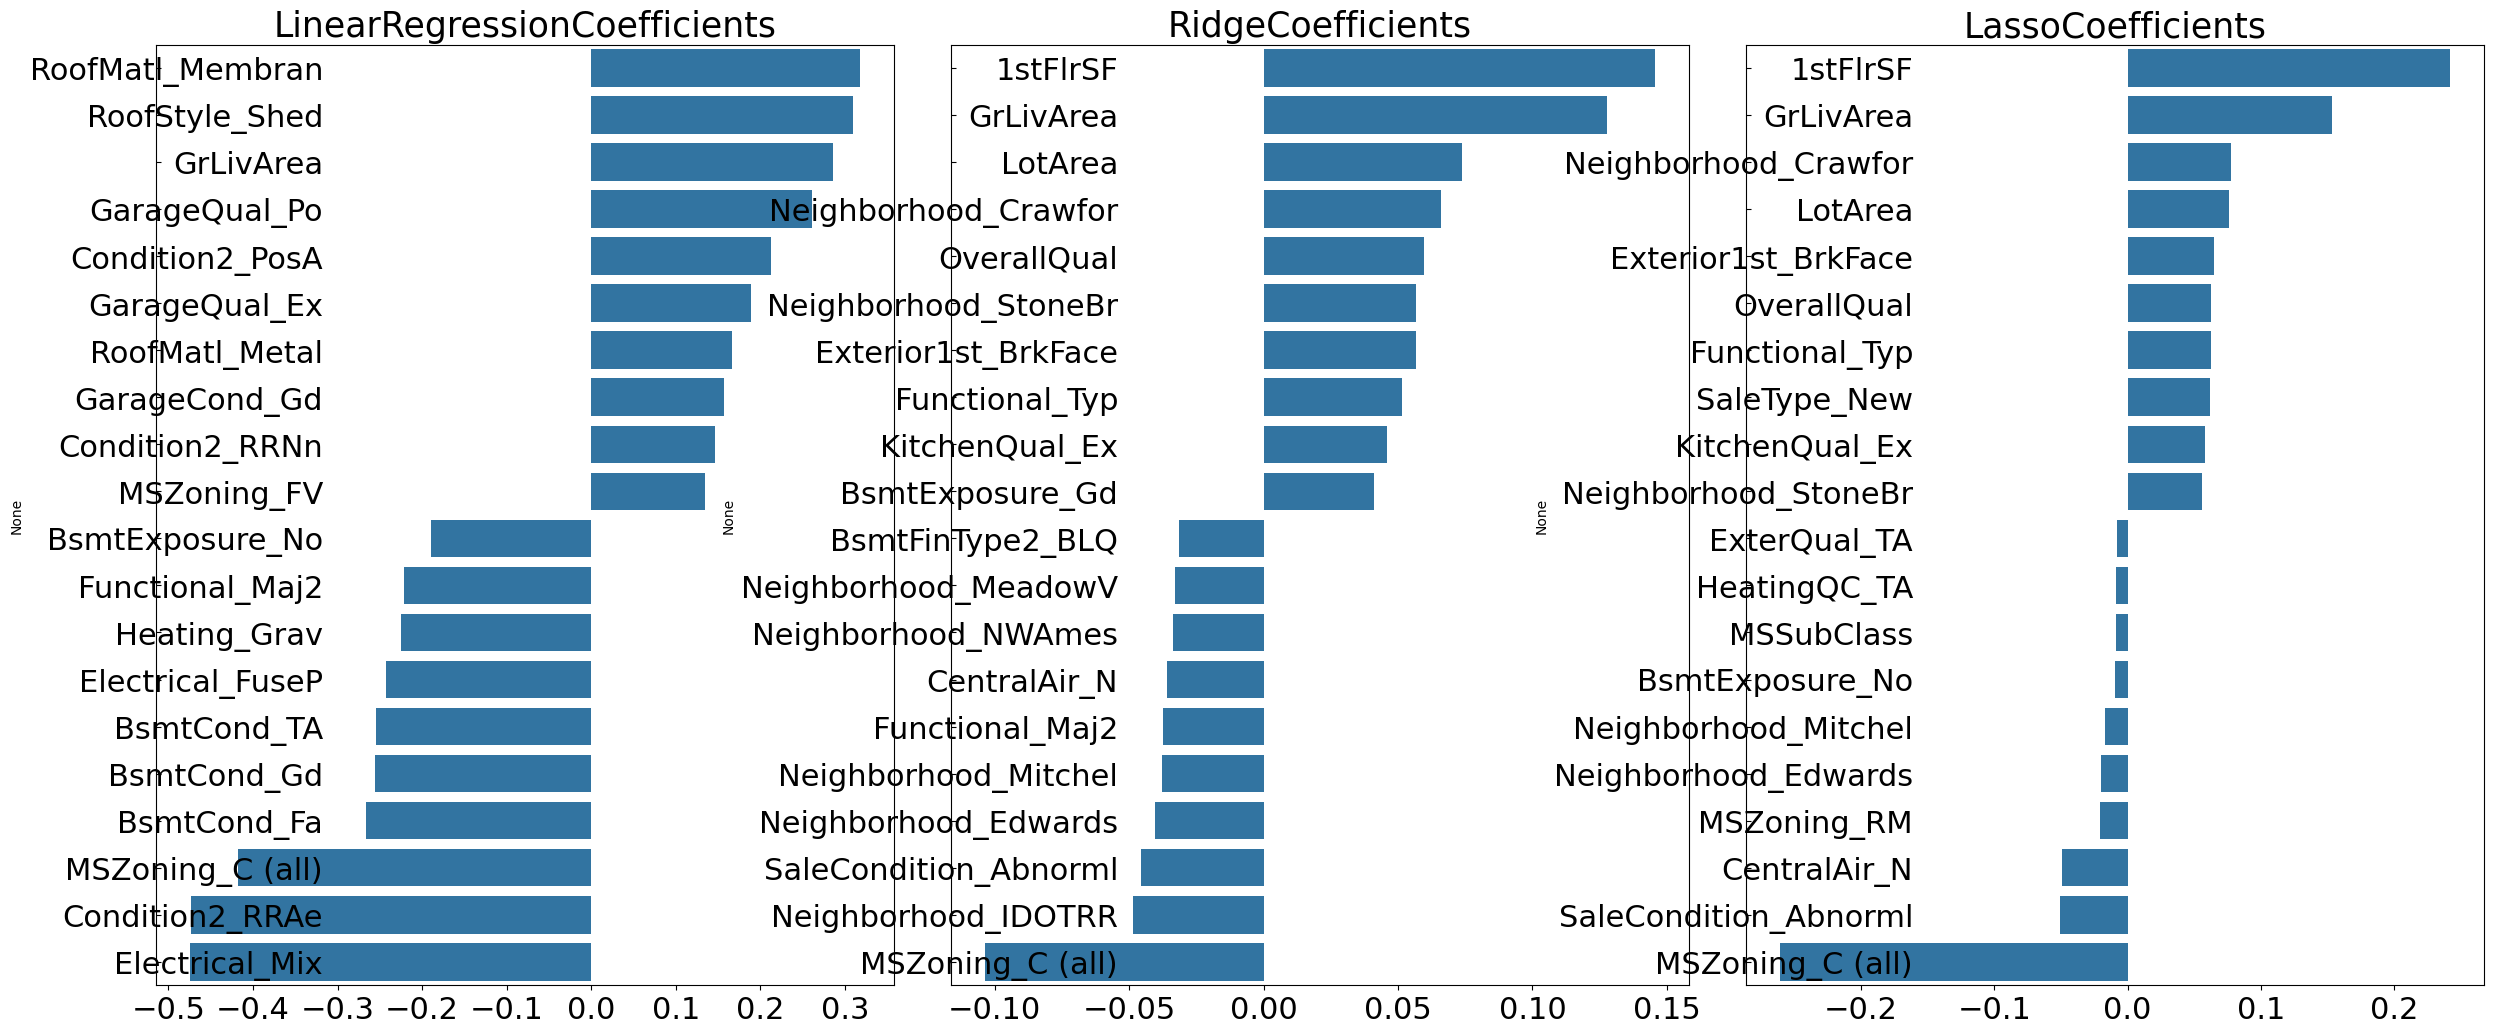

In [40]:
# 이상치 제거 후 최적화 alpha 값으로 train_test_split() 적용 후 학습
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=18)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

## **회귀 트리 모델 학습/예측/평가**

XGBRegressor(XGBoost), LGBMRegressor(LightGBM) 클래스 이용

In [41]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1185, 최적 alpha:{'n_estimators': 1000}


XGBoost 회귀 트리 적용 시 5-fold 평균 RMSE 0.1185

In [43]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                         colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, verbose=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값:0.1179, 최적 alpha:{'n_estimators': 1000}


5-fold 평균 RMSE 0.1179

In [47]:
# 피처 중요도 시각화를 위한 모델 학습
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.4, learning_rate=0.05, n_estimators=1000,
              n_jobs=-1, num_leaves=4, reg_lambda=10, subsample=0.6,
              verbose=-1)

In [57]:
# 피처 중요도 데이터 프레임 생성
xgb_features = pd.Series(xgb_reg.feature_importances_, index=X_features.columns)
lgbm_features = pd.Series(lgbm_reg.feature_importances_, index=X_features.columns)

# top20
xgb_features = xgb_features.sort_values(ascending=False)[:20]
lgbm_features = lgbm_features.sort_values(ascending=False)[:20]

<Axes: title={'center': 'LGBMRegressor Feature Importances'}, ylabel='None'>

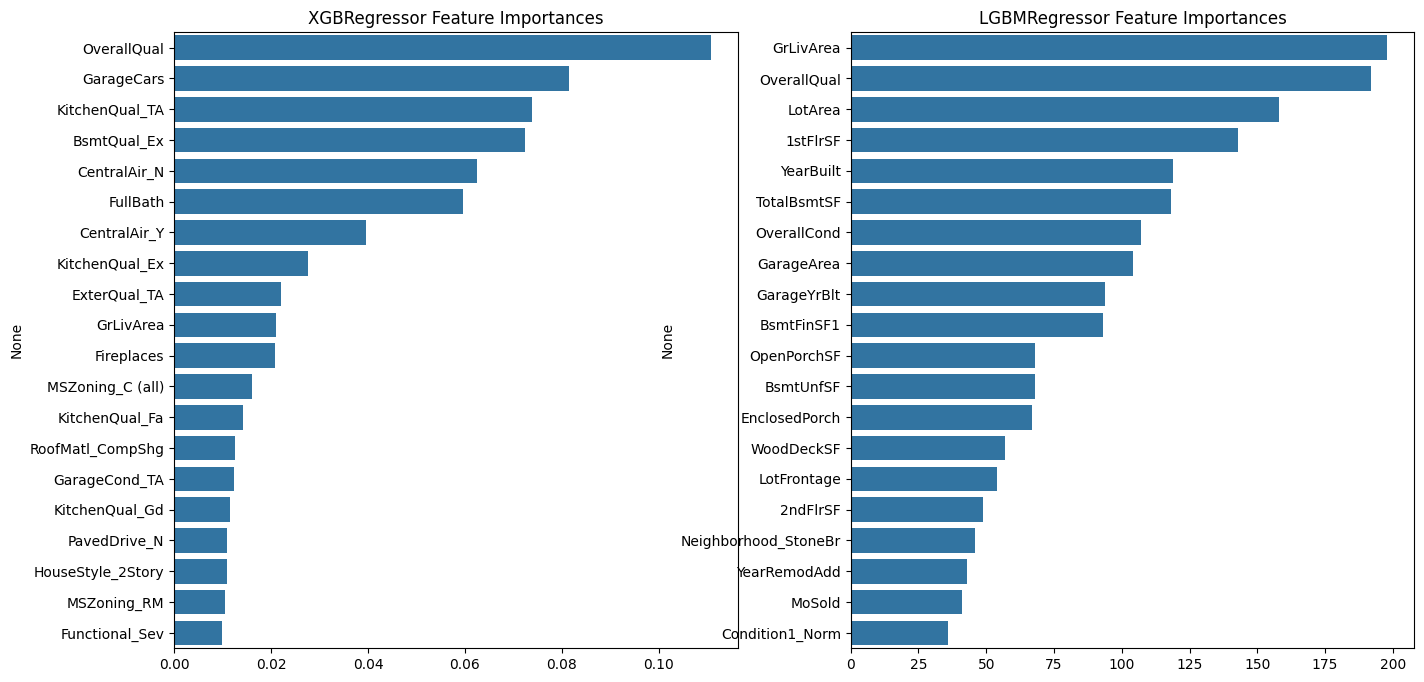

In [58]:
# 피처 중요도 시각화
fig, axs = plt.subplots(figsize=(16,8), ncols=2)

axs[0].set_title('XGBRegressor Feature Importances')
sns.barplot(x=xgb_features.values, y=xgb_features.index, ax=axs[0])

axs[1].set_title('LGBMRegressor Feature Importances')
sns.barplot(x=lgbm_features.values, y=lgbm_features.index, ax=axs[1])

## **회귀 모델의 예측 결과 혼합을 통한 최종 예측**

개별 회귀 모델의 예측 결과값을 혼합하여 이를 기반으로 최종 회귀값 예측

*예측 결과 혼합 방법 (A, B 두 모델의 예측값이 있다고 가정)*
* A 모델 예측값의 40%, B 모델 예측값의 60%를 더하여 최종 회귀 값으로 예측
    * A 모델 예측값 : [100, 80, 60] , B 모델 예측값 : [120, 80, 50]
    * 최종 예측값 : [100\*0.4 + 120\*0.6,  80\*0.4 + 80\*0.6,  60\*0.4 + 50\*0.6]

In [59]:
# 최종 혼합 모델, 개별 모델의 RMSE 값을 출력하는 함수 생성
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10006075517615194
Ridge 모델의 RMSE: 0.10340697165289348
Lasso 모델의 RMSE: 0.10024171179335342


각 모델의 결과값에 가하는 가중치는 정해진 것이 없음, 모델의 성능에 근거하여 두 모델 중 성능이 조금 더 좋은 쪽에 가중치를 둠

In [61]:
# XGBoost, LightGBM 혼합 결과 확인
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                         colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, verbose=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred + 0.5*lgbm_pred
preds = {'최종 혼합': pred,
         'XGB': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10208933384486087
XGB 모델의 RMSE: 0.10749463285555907
LGBM 모델의 RMSE: 0.10363891833477148


XGBoost, LightGBM의 혼합 모델의 RMSE가 개별 모델의 RMSE보다 조금 향상됨

##**스태킹 앙상블 모델을 통한 회귀 예측**

![Stacking](https://helpingstar.github.io/assets/images/ai/stacking_ex5.png)

In [62]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False)

    # 추후에 메타모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__,'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean


In [63]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
Lasso model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
XGBRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
LGBMRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작


In [64]:
# 각 개별 모델이 반환하는 학습/테스트 데이터 세트(피처)를 결합하여 최종 메타 모델에 적용
# 메타 모델은 별도의 라쏘모델

Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09762120850917913
